In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
import math
from PIL import Image

rink = Image.open('rink_simple.png')
rink.putalpha(100)

C:\Users\devli\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def calculate_strength(df):
    Skaters = []
    for i in range(len(df)):
        state = '?'
        if df.loc[i,'Team'] == df.loc[i,'Home Team']:
            state = str(df.loc[i,'Home Team Skaters']) + "v" + str(df.loc[i,'Away Team Skaters'])
        elif df.loc[i,'Team'] == df.loc[i,'Away Team']:
            state = str(df.loc[i,'Away Team Skaters']) + "v" + str(df.loc[i,'Home Team Skaters'])
        Skaters.append(state)
    return Skaters

def calculate_strength_general(df):
    states = []
    for i in range(len(df)):
        state = '?'
        if df.loc[i,'Team'] == df.loc[i,'Home Team']:
            if df.loc[i,'Home Team Skaters'] == df.loc[i,'Away Team Skaters']:
                state = "even strength"
            elif df.loc[i,'Home Team Skaters'] > df.loc[i,'Away Team Skaters']:
                state = "power play"
            else:
                state = "shorthanded"
        elif df.loc[i,'Team'] == df.loc[i,'Away Team']:
            if df.loc[i,'Away Team Skaters'] == df.loc[i,'Home Team Skaters']:
                state = "even strength"
            elif df.loc[i,'Away Team Skaters'] > df.loc[i,'Home Team Skaters']:
                state = "power play"
            else:
                state = "shorthanded"
        states.append(state)
    return states

In [3]:
def get_shot_dist_and_angle(df):
    Shot_distance = []
    Shot_angle = []
    for i in range(len(df)):
        sd = np.nan
        sa = np.nan
        if df.loc[i,'Event'] in ['Shot', 'Goal']:
            sd = ((df.loc[i,'X Coordinate'] - 189) ** 2 + (df.loc[i,'Y Coordinate'] - 42.5) ** 2)**0.5
            sa = np.arctan(abs(df.loc[i,'Y Coordinate'] - 42.5)/(189 - (df.loc[i,'X Coordinate'])))
            sa = sa * 180/np.pi
        Shot_distance.append(sd)
        Shot_angle.append(sa)
    df['Shot Angle'] = Shot_angle
    df['Shot Distance'] = Shot_distance
    return df

In [4]:
#xG features
#Shot Distance 'Shot Distance'
#Time since last event* 'Time Since Last'
#Shot Type 'Detail 1'
#Shot Angle 'Shot Angle'
#East/west mvmt from last event* 'Lateral Since Last'
#Rebound angle* ?
#Other team skaters* 'Opp Team Skaters'
#Is powerplay*
#print(df.columns)
#df.loc[df.Event == 'Shot']['Detail 1']

def find_diff_bt_events(df):
    elapsed_since_last = [np.nan]
    east_west_since_last = [np.nan]
    last_event = [np.nan]
    for j in range(1,len(df)):
        i = j-1
        time_delta = int(df.loc[i,'Clock'].split(':')[0]) * 60 + int(df.loc[i,'Clock'].split(':')[1]) \
                         - int(df.loc[j,'Clock'].split(':')[0]) * 60 - int(df.loc[j,'Clock'].split(':')[1])
        elapsed_since_last.append(time_delta)
        lateral_delta = abs(df.loc[i,'Y Coordinate'] - df.loc[j,'Y Coordinate'])
        last_event.append(df.loc[i,'Event'])
        east_west_since_last.append(lateral_delta)
    return elapsed_since_last, east_west_since_last, last_event

def find_time_bt_events(df):
    elapsed_since_last = [np.nan]
    for j in range(1,len(df)):
        i = j-1
        time_delta = int(df.loc[i,'Clock'].split(':')[0]) * 60 + int(df.loc[i,'Clock'].split(':')[1]) \
                         - int(df.loc[j,'Clock'].split(':')[0]) * 60 - int(df.loc[j,'Clock'].split(':')[1])
        elapsed_since_last.append(time_delta)
    return elapsed_since_last

def find_opp_team_skaters(df):
    opp_team_skaters = []
    for i in range(len(df)):
        if df.loc[i,'Team'] == df.loc[i,'Away Team']:
            opp_team_skaters = df.loc[i,'Home Team Skaters']
        else:
            opp_team_skaters = df.loc[i,'Away Team Skaters']
    return opp_team_skaters

In [5]:
def get_xG_inputs(df):
    #Use functions to get data about the prior event
    time_d, lat_d, lasts = find_diff_bt_events(df)
    df['Time Since Last'] = time_d
    df['Last Event Type'] = lasts
    df['Lateral Since Last'] = lat_d
    df['Opp Team Skaters'] = find_opp_team_skaters(df)
    #More categorical variables and target
    df['Is Powerplay'] = [1 if x == 'power play' else 0 for x in df['Strength'].tolist()]
    df['Is Goal'] = [1 if x == 'Goal' else 0 for x in df['Event'].tolist()]
    #Trim to only shots
    shot_df = df.loc[df.Event.isin(["Goal", "Shot"])]
    indices = shot_df.index.tolist()
    shot_df.reset_index(inplace=True)
    #Categorical variables for prior event type
    enc = OneHotEncoder()
    x = enc.fit_transform(shot_df[['Last Event Type']])
    headers = (enc.categories_)
    headers = (['Last Was ' + str(x) for x in headers[0]])
    rows = enc.transform(shot_df[['Last Event Type']]).toarray()
    cat_data = pd.DataFrame(data = rows, columns = headers)
    cat_data
    for h in headers:
        shot_df[h] = cat_data[h]
    #Categorical variables for shot type
    enc2 = OneHotEncoder()
    x = enc2.fit_transform(shot_df[['Detail 1']])
    headers = (enc2.categories_)
    headers = ([str(x) for x in headers[0]])
    rows = enc2.transform(shot_df[['Detail 1']]).toarray()
    cat_data = pd.DataFrame(data = rows, columns = headers)
    cat_data
    for h in headers:
        shot_df[h] = cat_data[h]
    #Select and return xG model inputs and target
    inputs = shot_df.reset_index()[['X Coordinate', 'Y Coordinate', 'Shot Angle', 'Shot Distance', 'Time Since Last',
       'Lateral Since Last', 'Opp Team Skaters', 'Is Powerplay', \
       #'Last Was Play', <- omitted
       'Last Was Puck Recovery', \
       'Last Was Shot', 'Last Was Takeaway', 'Last Was Zone Entry', \
       'Deflection', 'Fan', 'Slapshot', 'Snapshot', 'Wrap Around', \
       #'Wristshot' <- omitted
       ]]

    labels = shot_df.reset_index()['Is Goal']
    return inputs, labels, indices

In [6]:
def train_xg_model(x,y):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    kf.get_n_splits(x)
    clf = LogisticRegressionCV(#Cs=list(np.power(10.0, np.arange(-10, 10))), penalty = 'l2', \
                               scoring='roc_auc', cv=kf,random_state=0,max_iter=10000,fit_intercept=True \
                               ,solver='newton-cg', tol=10)
    clf.fit(x, y)
    #print(clf.score(inputs,labels))
    coefs = pd.DataFrame(list(zip(np.array(x.columns),clf.coef_.T)), \
                   columns = ['Variable','Coef']).sort_values(['Coef'], ascending=False)
    print(coefs)
    return clf

In [7]:
df_women = pd.read_csv('https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv')
df_scouting = pd.read_csv('https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv')
df_nwhl = pd.read_csv('https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_nwhl.csv')

In [8]:
len(df_women)

24002

In [9]:
def shot_feature_adder(df):
    nwhl = df
    dfw = get_shot_dist_and_angle(nwhl)
    dfw['Skaters'] = calculate_strength(dfw)
    dfw['Strength'] = calculate_strength_general(dfw)
    w_inp, w_lab, w_ind = get_xG_inputs(dfw)
    xgw = train_xg_model(w_inp, w_lab)
    w_pred = xgw.predict_proba(w_inp)[:,1]
    dfw['xG'] = [np.nan for i in range(len(dfw))]
    for i in range(len(w_ind)):
        dfw.loc[w_ind[i],'xG'] = w_pred[i]
    return dfw

In [10]:
def clocktime(clock):
    time = int(clock.split(':')[0]) * 60 + int(clock.split(':')[1])
    return time

def dist(a,b):
    runtot = 0
    for i in range(len(a)):
        runtot += (a[i] - b[i]) ** 2
    return runtot ** 0.5

In [11]:
scouting = shot_feature_adder(df_women)
scouting['Is Point'] = [1 if (x > 125 and x < 135) else 0 for x in scouting['X Coordinate']]
scouting['Is Mid'] = [1 if (y > 20 and y < 65) else 0 for y in scouting['Y Coordinate']]
scouting['xg_pm_45'] = [np.nan for i in range(len(scouting))]
scouting['c_pm_45'] = [np.nan for i in range(len(scouting))]

for i in range(len(scouting)):
    if scouting.loc[i,'Event'] in ['Play', 'Incomplete Play']:
        xg_pm = 0
        c_pm = 0
        start_time = clocktime(scouting.loc[i,'Clock'])
        start_team = scouting.loc[i,'Team']
        for j in range(i,len(scouting)):
            curr_time = clocktime(scouting.loc[j,'Clock'])
            if curr_time < start_time - 45 or curr_time > start_time:
                break
            if scouting.loc[j,'Event'] in ['Shot', 'Goal']:
                if scouting.loc[j,'Team'] == start_team:
                    xg_pm += scouting.loc[j,'xG']
                    c_pm += 1
                else:
                    xg_pm += scouting.loc[j,'xG'] * -1
                    c_pm += -1
            if scouting.loc[j,'Event'] == 'Goal':
                break
        scouting.loc[i,'xg_pm_45'] = xg_pm
        scouting.loc[i,'c_pm_45'] = c_pm
    else:
        pass

C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                  Variable                     Coef
15                Snapshot     [0.0884417715482438]
11     Last Was Zone Entry    [0.04872058642220829]
12              Deflection    [0.04818834282609898]
14                Slapshot    [0.03614857574742096]
9            Last Was Shot    [0.03535624615308508]
6         Opp Team Skaters    [0.03288992991818828]
5       Lateral Since Last   [0.022839324112240357]
1             Y Coordinate   [0.012638388417403806]
10       Last Was Takeaway   [0.000984304874490347]
7             Is Powerplay    [-0.0041210016539339]
2               Shot Angle   [-0.00905328998043422]
0             X Coordinate  [-0.010015435466234925]
16             Wrap Around   [-0.03497502876760541]
13                     Fan   [-0.03679535844312441]
3            Shot Distance    [-0.0870864524947273]
8   Last Was Puck Recovery   [-0.10244381021745298]
4          Time Since Last    [-0.2457789414237796]


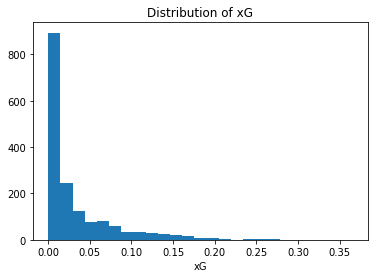

In [18]:
plt.hist(x=scouting['xG'].dropna(), bins = 25)
plt.title('Distribution of xG')
plt.xlabel('xG')
plt.show()

In [28]:
pass_features = scouting.loc[scouting.Event.isin(['Play', 'Incomplete Play'])]
pass_features['successful'] = [1 if x == 'Play' else 0 for x in pass_features['Event'].tolist()]
pass_features = pass_features.loc[pass_features['Is Powerplay'] != 1]
pass_features['origin'] = pass_features[['X Coordinate', 'Y Coordinate']].values.tolist()
pass_features['destination'] = pass_features[['X Coordinate 2', 'Y Coordinate 2']].values.tolist()
pass_features.columns
pass_features['Direct'] = [1 if x == 'Direct' else 0 for x in pass_features['Detail 1'].tolist()]

C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
passX = pass_features[['X Coordinate', 'Y Coordinate', 'Direct', 'X Coordinate 2', 'Y Coordinate 2', 'Time Since Last', 'Lateral Since Last']]
passV = pass_features['xg_pm_45']
passS = pass_features['successful']

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
X_train, X_test, y_train, y_test = train_test_split(passX, passS, test_size=0.3, random_state=420)
gbc.fit(X_train,y_train)
y_pred = gbc.predict_proba(X_test)
gbc.score(X_test,y_test)
pd.DataFrame(gbc.feature_importances_, index = passX.columns).sort_values(by=0)

,0
Time Since Last,0.018923
Lateral Since Last,0.046210
Direct,0.047334
Y Coordinate,0.124982
Y Coordinate 2,0.175312
X Coordinate,0.175343
X Coordinate 2,0.411896


In [69]:
success_odds = [y[1] for y in y_pred]
test_passes = pass_features.loc[y_test.index.tolist()].copy()
test_passes['predicted'] = success_odds

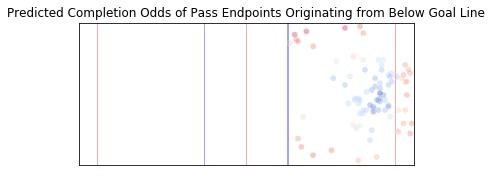

In [79]:
low_passes = test_passes.loc[(test_passes['X Coordinate'] > 190) & (test_passes.Direct == 1)]
plt.xlim(0,200)
plt.ylim(0,85)
plt.title('Predicted Completion Odds of Pass Endpoints Originating from Below Goal Line')
plt.imshow(rink)
sns.scatterplot(x='X Coordinate 2', y='Y Coordinate 2', data = low_passes, hue = 'predicted', \
                alpha = .3, palette = 'coolwarm')
plt.legend().remove()
plt.xticks([], [])
plt.yticks([], [])
plt.ylabel('')
plt.xlabel('')
plt.savefig('goaline.png', dpi=200)

In [83]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
X_train, X_test, y_train, y_test = train_test_split(passX, passV, test_size=0.3, random_state=111)
gbr.fit(X_train,y_train)
y_pred2 = gbr.predict(X_test)
gbr.score(X_test,y_test)
pd.DataFrame(gbr.feature_importances_, index = passX.columns).sort_values(by=0)

,0
Direct,0.027868
Time Since Last,0.044669
Lateral Since Last,0.082253
Y Coordinate 2,0.113537
Y Coordinate,0.118240
X Coordinate,0.236228
X Coordinate 2,0.377205


In [85]:
success_odds = [y for y in y_pred2]
test_passes = pass_features.loc[y_test.index.tolist()].copy()
test_passes['predicted'] = success_odds

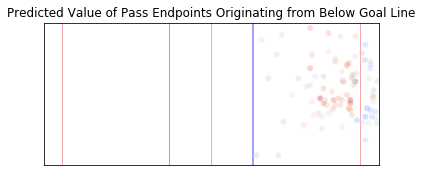

In [87]:
low_passes = test_passes.loc[(test_passes['X Coordinate'] > 190) & (test_passes.Direct == 1)]
plt.xlim(0,200)
plt.ylim(0,85)
plt.title('Predicted Value of Pass Endpoints Originating from Below Goal Line')
plt.imshow(rink)
sns.scatterplot(x='X Coordinate 2', y='Y Coordinate 2', data = low_passes, hue = 'predicted', \
                alpha = .3, palette = 'coolwarm')
plt.legend().remove()
plt.xticks([], [])
plt.yticks([], [])
plt.ylabel('')
plt.xlabel('')
plt.savefig('goaline.png', dpi=200)

In [14]:
passes = pass_features.loc[pass_features['X Coordinate'] > 125].reset_index(drop = False)

nearest = []
nearest_d = []

for i in range(len(passes)):
    dists = []
    ix = passes.loc[i,'X Coordinate']
    for j in range(len(passes)):
        o_dist = dist(passes.loc[i,'origin'], passes.loc[j,'origin'])
        d_dist = dist(passes.loc[i,'destination'], passes.loc[j,'destination'])
        comb_dist = o_dist + d_dist
        dists.append(comb_dist)
    nearest_d.append(sorted(dists)[:100])
    nearest.append(sorted(range(len(dists)), key=lambda k: dists[k])[:100])
    if i % 100 == 0:
        print(str(i) + " out of " + str(len(passes)))
    
passes['nearest'] = nearest
passes['nearest_d'] = nearest_d
#passes.to_csv('test.csv')

0 out of 9580
100 out of 9580
200 out of 9580
300 out of 9580
400 out of 9580
500 out of 9580
600 out of 9580
700 out of 9580
800 out of 9580
900 out of 9580
1000 out of 9580
1100 out of 9580
1200 out of 9580
1300 out of 9580
1400 out of 9580
1500 out of 9580
1600 out of 9580
1700 out of 9580
1800 out of 9580
1900 out of 9580
2000 out of 9580
2100 out of 9580
2200 out of 9580
2300 out of 9580
2400 out of 9580
2500 out of 9580
2600 out of 9580
2700 out of 9580
2800 out of 9580
2900 out of 9580
3000 out of 9580
3100 out of 9580
3200 out of 9580
3300 out of 9580
3400 out of 9580
3500 out of 9580
3600 out of 9580
3700 out of 9580
3800 out of 9580
3900 out of 9580
4000 out of 9580
4100 out of 9580
4200 out of 9580
4300 out of 9580
4400 out of 9580
4500 out of 9580
4600 out of 9580
4700 out of 9580
4800 out of 9580
4900 out of 9580
5000 out of 9580
5100 out of 9580
5200 out of 9580
5300 out of 9580
5400 out of 9580
5500 out of 9580
5600 out of 9580
5700 out of 9580
5800 out of 9580
5900 out 

In [115]:
#compute expected completion percentage/ avg xG
passes = pd.read_csv('test.csv', index_col = 0)
passes['nearest'] = passes.nearest.str.strip('[').str.strip(']').str.split(',')
passes['nearest_d'] = passes.nearest_d.str.strip('[').str.strip(']').str.split(',')
xG_comp = []
xG_fail = []
completion_rate = []
for index_to_test in range(len(passes)):
    temp_completion_rate = []
    tempXG_comp = []
    tempXG_fail = []
    j = 0
    while j < 50:
        i = int(passes.loc[index_to_test,'nearest'][j].strip(' '))
        if i == index_to_test:
            pass
        elif passes.loc[i,'Event'] == 'Play':
            tempXG_comp.append(passes.loc[i, 'xg_pm_45'])
            temp_completion_rate.append(1)
        else:
            tempXG_fail.append(passes.loc[i, 'xg_pm_45'])
            temp_completion_rate.append(0)
        j += 1
    xG_comp.append(sum(tempXG_comp)/len(tempXG_comp))
    xG_fail.append(sum(tempXG_fail)/len(tempXG_fail))
    completion_rate.append(sum(temp_completion_rate)/len(temp_completion_rate))

    
passes['similarCompXG'] = xG_comp
passes['similarFailXG'] = xG_fail
passes['expectedCompletionRate'] = completion_rate
#float(passes.loc[1,'nearest_d'][j].strip(' '))

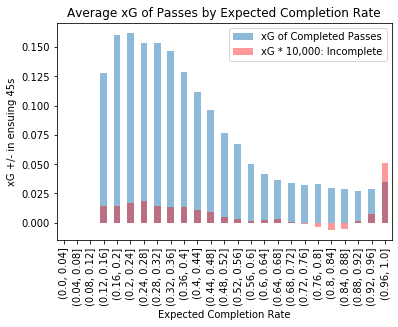

,expectedCompletionRate,similarCompXG,similarFailXG,count
0,"(0.0, 0.04]",NaN,NaN,0
1,"(0.04, 0.08]",NaN,NaN,0
2,"(0.08, 0.12]",NaN,NaN,0
3,"(0.12, 0.16]",0.128038,0.014544,15
4,"(0.16, 0.2]",0.160320,0.014541,56
5,"(0.2, 0.24]",0.162310,0.016448,122
6,"(0.24, 0.28]",0.153898,0.018230,165
7,"(0.28, 0.32]",0.153298,0.013919,192
8,"(0.32, 0.36]",0.146472,0.013736,184
9,"(0.36, 0.4]",0.128365,0.013407,281


In [171]:
from pandasql import sqldf
bins = [x/25 for x in range(26)]
p_mean = passes.groupby(pd.cut(passes.expectedCompletionRate, bins)).mean().iloc[:,:-1]
p_count = passes.groupby(pd.cut(passes.expectedCompletionRate, bins)).count().iloc[:,:-1]
p_mean['count'] = p_count['index']
pass_summary = p_mean[['similarCompXG', 'similarFailXG', 'count']].reset_index(drop=False)
pass_summary

fig, ax = plt.subplots()
pass_summary.plot.bar('expectedCompletionRate','similarCompXG', alpha=.5, ax=ax, label = 'xG of Completed Passes')
pass_summary.plot.bar('expectedCompletionRate','similarFailXG', alpha=.4, ax=ax, label = 'xG * 10,000: Incomplete', color = 'r')
#pass_summary.plot.bar('expectedCompletionRate','count', alpha=.4, ax=ax, color='r')
ax.set_title("Average xG of Passes by Expected Completion Rate")
ax.set_ylabel('xG +/- in ensuing 45s')
ax.set_xlabel('Expected Completion Rate')
plt.show()
pass_summary

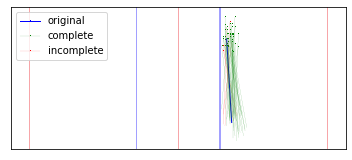

<Figure size 30000x20000 with 0 Axes>

In [150]:
index_to_test = 33
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(rink)
plt.ylim(0,85)
plt.xlim(0,200)
pc = 0
ic = 0
for i in passes.loc[index_to_test,'nearest'][:50]:
    i = int(i.strip(' '))
    x1 = passes.loc[i,'X Coordinate']
    x2 = passes.loc[i,'X Coordinate 2']
    y1 = passes.loc[i,'Y Coordinate']
    y2 = passes.loc[i,'Y Coordinate 2']
    if i == index_to_test:
        plt.plot([x1,x2],[y1,y2],'b,-', markevery=2,lw=1, label = 'original')
    elif passes.loc[i,'Event'] == 'Play':
        if pc == 0:
            plt.plot([x1,x2],[y1,y2],'g,-', markevery=2,lw=0.1, label = 'complete')
            pc += 1
        else:
            plt.plot([x1,x2],[y1,y2],'g,-', markevery=2,lw=0.1)
    else:
        if ic == 0:
            plt.plot([x1,x2],[y1,y2],'r,-', markevery=2,lw=0.1, label = 'incomplete')
            ic += 1
        else:
            plt.plot([x1,x2],[y1,y2],'r,-', markevery=2,lw=0.1)
plt.legend(loc='upper left')
plt.figure(dpi=5000)
plt.show()

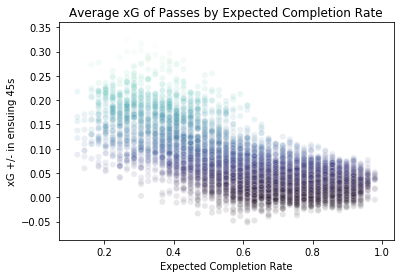

In [162]:
fig, ax = plt.subplots()
sns.scatterplot(x='expectedCompletionRate', y = 'similarCompXG', data = passes, alpha = .1, ax=ax, hue = 'similarCompXG', palette = 'mako')
ax.set_title("Average xG of Passes by Expected Completion Rate")
ax.set_ylabel('xG +/- in ensuing 45s')
ax.set_xlabel('Expected Completion Rate')
ax.get_legend().remove()
plt.show()

In [32]:
#TODO:
avg_incomplete_xg = passes.loc[passes.Event == 'Incomplete Play']['xg_pm_45'].mean()
#Compare xG to bin by complete-ability
#or - find best passes by origin
#Find most efficient passes
passes['efficiency'] = passes['expectedCompletionRate'] * passes['similarCompXG']

In [163]:
effp = passes.sort_values('similarCompXG', ascending = False)

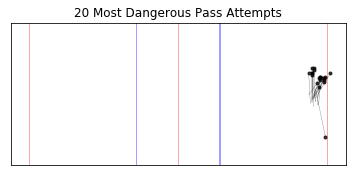

In [170]:
fig, ax = plt.subplots()
plt.xlim(0,200)
plt.xticks([], [])
plt.yticks([], [])
plt.ylim(0,85)
plt.imshow(rink)
plt.title('20 Most Dangerous Pass Attempts')
for i in effp.index.tolist()[:20]:
    x1 = effp.loc[i,'X Coordinate']
    x2 = effp.loc[i,'X Coordinate 2']
    y1 = effp.loc[i,'Y Coordinate']
    y2 = effp.loc[i,'Y Coordinate 2']
    col = 'k'
#     if effp.loc[i,'similarPassAvgXG'] > .015:
#         col = '#42f587'
#     if pointPasses.loc[i,'similarPassAvgXG'] > .03:
#         col = '#f5ce42'
#     if pointPasses.loc[i,'similarPassAvgXG'] > .045:
#         col = 'r'
    plt.plot([x1,x2],[y1,y2], color = col, markevery=2,lw=.25,marker=".", alpha = .75)
plt.show()

In [292]:
pointPasses = passes.loc[(passes['X Coordinate'] <136) & (passes['Detail 1'] != 'Indirect')]

In [293]:
pointPassesReg = pointPasses.copy()
#pointPassesReg['Y Coordinate'] = [y if y < 42.5 else 85 - y for y in pointPasses['Y Coordinate'].tolist()]
#pointPassesReg['Y Coordinate 2'] = [y if y < 42.5 else 85 - y for y in pointPasses['Y Coordinate'].tolist()]
pointPassesReg['efficiency'] = pointPassesReg['expectedCompletionRate'] * pointPassesReg['similarCompXG']

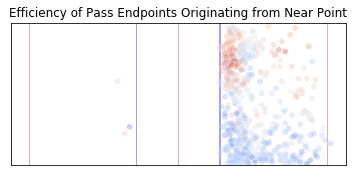

In [299]:
pointPassesReg = pointPassesReg.loc[pointPassesReg['Y Coordinate'] < 42.5]
plt.xlim(0,200)
plt.ylim(0,85)
plt.title('Efficiency of Pass Endpoints Originating from Near Point')
pointPassesReg.sort_values('efficiency', ascending = False)
plt.imshow(rink)
# for i in pointPassesReg.index.tolist():
#     x1 = pointPassesReg.loc[i,'X Coordinate']
#     x2 = pointPassesReg.loc[i,'X Coordinate 2']
#     y1 = pointPassesReg.loc[i,'Y Coordinate']
#     y2 = pointPassesReg.loc[i,'Y Coordinate 2']
#     col = '#4287f5'
#     if pointPassesReg.loc[i,'efficiency'] > .015:
#         col = '#42f587'
#     if pointPassesReg.loc[i,'efficiency'] > .03:
#         col = '#f5ce42'
#     if pointPassesReg.loc[i,'efficiency'] > .045:
#         col = 'r'
#     plt.plot([x1,x2],[y1,y2], color = col, markevery=2,lw=.25,marker=".")
sns.scatterplot(x='X Coordinate 2', y='Y Coordinate 2', data = pointPassesReg, hue = 'efficiency', \
                alpha = .3, palette = 'coolwarm')
plt.legend().remove()
plt.xticks([], [])
plt.yticks([], [])
plt.ylabel('')
plt.xlabel('')
plt.savefig('goaline.png', dpi=200)

In [59]:
len(pointPassesReg)

ppr = pointPassesReg[['X Coordinate 2', 'Y Coordinate 2', 'efficiency']]

(array([  1.,   5.,  15.,  54.,  78.,  88., 150., 186., 149., 126.,  72.,
         79.,  82.,  37.,  11.]),
 array([-0.01031611, -0.00545016, -0.00058422,  0.00428172,  0.00914767,
         0.01401361,  0.01887955,  0.02374549,  0.02861144,  0.03347738,
         0.03834332,  0.04320926,  0.04807521,  0.05294115,  0.05780709,
         0.06267304]),
 <a list of 15 Patch objects>)

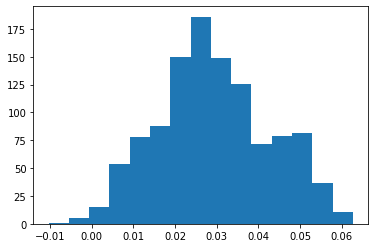

In [88]:
plt.hist(x=pointPassesReg['efficiency'], bins = 15)

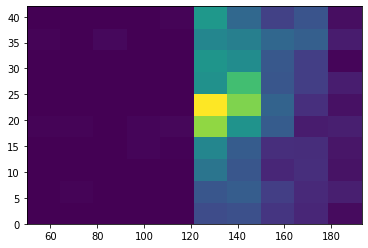

In [257]:
plt.xlim(0,200)
plt.ylim(0,85)
plt.hist2d(pointPassesReg['X Coordinate 2'],pointPassesReg['Y Coordinate 2'], weights = pointPassesReg['efficiency'])
plt.show()

In [72]:
passes['value'] = passes['successful'] * passes['xg_pm_45']

In [74]:
player_df = passes.loc[passes.Team == 'Erie Otters'].groupby('Player').mean()

In [75]:
player_df['delta'] = player_df['value'] - player_df['efficiency']

-7.470402238283267


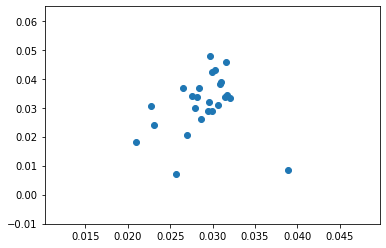

In [86]:
print(r2_score(player_df['efficiency'], player_df['value']))
plt.scatter(x = player_df['efficiency'], y = player_df['value'])
plt.show()

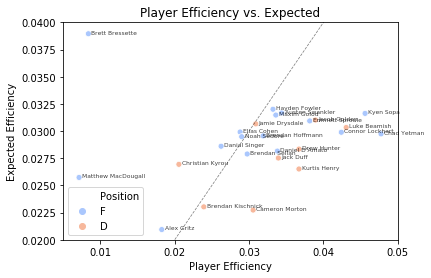

In [244]:
fig, ax = plt.subplots()

ax.plot([0,1],[0,1], color = 'k', alpha = 0.5, linestyle = 'dashed', lw = .75)
ax.set_ylim(.02,.04)
ax.set_xlim(.005,.05)
sns.scatterplot(ax = ax, data = player_df, x = 'value', y = 'efficiency', hue = 'Position', palette = 'coolwarm')
ax.set_xlabel("Player Efficiency")
ax.set_ylabel("Expected Efficiency")
ax.set_title('Player Efficiency vs. Expected')
for i in player_df.index.tolist():
    ax.text(player_df.loc[i,'value'] + .0004, player_df.loc[i,'efficiency'], i, size = 6, alpha = .75)
plt.savefig('testjpg.png', dpi = 200)

In [200]:
player_df['CompOverExpected'] = player_df['successful'] - player_df['expectedCompletionRate']
player_df['xgOverExpected'] = player_df['xg_pm_45'] - player_df['similarCompXG']
player_df = player_df.rename({'similarCompXG':'Attempted Pass Danger'})

In [215]:
pos = []
for i in player_df.index.tolist():
    if i in ["Jamie Drysdale",
"Jacob Golden",
"Drew Hunter",
"Kurtis Henry",
"Jack Duff",
"Cameron Morton",
"Brendan Kischnick",
"Luke Beamish",
"Christian Kyrou"]:
        pos.append('D')
    else:
        pos.append('F')
player_df['Position'] = pos

In [179]:
passes.loc[passes['Player'] == 'Christian Kyrou']

,index,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,...,xg_pm_45,c_pm_45,successful,origin,destination,nearest,nearest_d,similarCompXG,similarFailXG,expectedCompletionRate
2792,21565,2019-11-09,Barrie Colts,Erie Otters,1,14:51,5,5,0,0,...,-0.106148,-1.0,0,"[143, 71]","[126.0, 32.0]","[2792, 7072, 1842, 7605, 4992, 5246, 243...","[0.0, 9.508270432752164, 9.571155468592364, ...",0.069139,-0.014345,0.795918
2911,22473,2019-11-09,Barrie Colts,Erie Otters,2,5:40,5,5,0,4,...,0.112276,2.0,1,"[145, 73]","[131.0, 22.0]","[2911, 4800, 6772, 1488, 5748, 1549, 866...","[0.0, 3.6502815398728847, 7.404918347287664,...",0.041762,0.052999,0.816327
2983,23008,2019-11-09,Barrie Colts,Erie Otters,3,8:44,5,5,1,4,...,0.000000,0.0,0,"[146, 82]","[196.0, 50.0]","[2983, 2098, 2315, 667, 4717, 2426, 580,...","[0.0, 1.4142135623730951, 2.8284271247461903...",0.026555,0.004277,0.591837
3015,23354,2019-11-15,Erie Otters,Windsor Spitfires,1,17:42,5,5,0,0,...,-0.042517,-1.0,1,"[129, 84]","[159.0, 63.0]","[3015, 5331, 4124, 2016, 63, 1646, 25, ...","[0.0, 8.123105625617661, 8.485281374238571, ...",0.061828,-0.000026,0.428571
3033,23491,2019-11-15,Erie Otters,Windsor Spitfires,1,13:51,5,5,1,0,...,0.215196,1.0,1,"[134, 44]","[133.0, 4.0]","[3033, 4795, 9388, 2106, 8999, 7704, 634...","[0.0, 6.0, 10.0, 10.233345472033855, 10.23...",0.013757,0.024406,0.918367
3111,24200,2019-11-15,Erie Otters,Windsor Spitfires,2,10:49,5,5,1,2,...,0.050413,1.0,1,"[140, 69]","[154.0, 48.0]","[3111, 1934, 5425, 4146, 5339, 4032, 685...","[0.0, 5.123105625617661, 5.60555127546399, ...",0.099614,-0.057306,0.612245
3240,25304,2019-11-17,Mississauga Steelheads,Erie Otters,1,16:42,5,5,0,1,...,0.000000,0.0,1,"[132, 84]","[163.0, 80.0]","[3240, 9569, 5213, 2104, 1514, 5699, 570...","[0.0, 3.414213562373095, 3.8284271247461903,...",0.043357,-0.031159,0.448980
3266,25679,2019-11-17,Mississauga Steelheads,Erie Otters,1,4:18,5,5,1,1,...,0.000000,0.0,1,"[128, 31]","[132.0, 2.0]","[3266, 5007, 6290, 2809, 7368, 907, 4703...","[0.0, 5.60555127546399, 6.123105625617661, ...",0.009110,0.003214,0.836735
3327,26074,2019-11-17,Mississauga Steelheads,Erie Otters,2,11:39,5,5,1,1,...,-0.348903,-4.0,0,"[134, 79]","[142.0, 26.0]","[3327, 8095, 1121, 1399, 2109, 8569, 115...","[0.0, 3.23606797749979, 5.830951894845301, ...",0.043196,0.023519,0.816327
3384,26627,2019-11-17,Mississauga Steelheads,Erie Otters,3,12:49,5,5,2,2,...,0.018867,1.0,1,"[127, 43]","[167.0, 30.0]","[3384, 8586, 4231, 4843, 888, 789, 7612,...","[0.0, 14.31623326908387, 16.67869157073328, ...",0.070556,0.059915,0.530612


In [251]:
eval_df = player_df.sort_values('delta', ascending=False)[['delta','Position']]

In [256]:
eval_df.rename(columns = {'delta':'Efficiency Delta'}).head(5)

,Efficiency Delta,Position
Player,,
Chad Yetman,0.017991,F
Kyen Sopa,0.013965,F
Luke Beamish,0.012720,D
Connor Lockhart,0.012504,F
Kurtis Henry,0.010190,D
